# CUDA vs CPU performace testing on Multiple Resolutions


In [1]:
CODE_ROOT = pwd() * "/"

"/home/rrs/Desktop/MPAS_Ocean/"

In [12]:
include(CODE_ROOT * "mode_forward/time_steppers.jl")
include(CODE_ROOT * "mode_init/mode_init.jl")
include(CODE_ROOT * "visualization.jl")


using PyPlot
using PyCall

animation  = pyimport("matplotlib.animation")
ipydisplay = pyimport("IPython.display")


using BenchmarkTools

import CUDA

# Initial 1:1 test

In [3]:
mpasOcean = MPAS_Ocean(false, CODE_ROOT * "./MPAS_O_Shallow_Water/Mesh+Initial_Condition+Registry_Files/Periodic",
                    "base_mesh.nc",
                    "mesh.nc")
typeof(mpasOcean)

MPAS_Ocean

In [4]:
bench = @benchmark forward_backward_step!(mpasOcean)

BechmarkTools.Trial: 265 samples with 1 evaluations.
 Range (min … max):  17.407 ms … 22.514 ms  ┊ GC (min … max): 0.00% … 12.43%
 Time  (median):     18.124 ms              ┊ GC (median):    0.00%
 Time  (mean ± σ):   18.922 ms ±  1.311 ms  ┊ GC (mean ± σ):  5.37% ±  6.24%

     ▆█▂   ▂▃                               ▄▂                 
  ▅▅▄███▆▇▅███▃▃▃▃▃▁▃▃▃▃▁▁▃▁▁▁▁▁▃▁▁▁▁▁▁▁▄▄▄▅██▃▄▄▄▄██▆▃▃▁▃▃▃▃ ▃
  17.4 ms         Histogram: frequency by time        21.3 ms <

 Memory estimate: 17.05 MiB, allocs estimate: 955191.

In [5]:
moveArrays!(mpasOcean, CUDA.CuArray)

In [6]:
bench2 = @benchmark forward_backward_step_cuda!(mpasOcean)

BechmarkTools.Trial: 10000 samples with 1 evaluations.
 Range (min … max):  17.126 μs …  4.354 ms  ┊ GC (min … max): 0.00% … 98.94%
 Time  (median):     50.001 μs              ┊ GC (median):    0.00%
 Time  (mean ± σ):   49.497 μs ± 62.514 μs  ┊ GC (mean ± σ):  1.74% ±  1.40%

  ▃▄▂                                       ▁▅██▆▂            ▂
  ███▇▅▄▄▃▃▁▃▃▃▃▁▁▁▁▁▁▅▃▅▅▆▄▆▆▅▁▄▄▃▁▃▃▃▃▄▁▅▇██████▇▇▇▆▆▆▄▆▆▆▆ █
  17.1 μs      Histogram: log(frequency) by time      60.2 μs <

 Memory estimate: 8.97 KiB, allocs estimate: 178.

# Compare benchmarks of 6 meshes
see how performance scales with resolution 

In [8]:
base_path = CODE_ROOT * "MPAS_O_Shallow_Water/MPAS_O_Shallow_Water_Mesh_Generation/ConvergenceStudyMeshes/"

"/home/rrs/Desktop/MPAS_Ocean/MPAS_O_Shallow_Water/MPAS_O_Shallow_Water_Mesh_Generation/ConvergenceStudyMeshes/"

In [9]:
function time_resolution_test(; step = forward_backward_step!, arraytype=Array, cases=6, periodicity="Periodic")
    nncells = []

    ttimes = []

    cases = 6

    for iCase in 1:cases
        if periodicity == "Periodic"
            base_mesh_file_name = "base_mesh_$iCase.nc"
        else
            base_mesh_file_name = "culled_mesh_$iCase.nc"
        end
        mesh_file_name = "mesh_$iCase.nc"
        mpasOcean = MPAS_Ocean(false, base_path * periodicity, base_mesh_file_name, mesh_file_name, periodicity=periodicity)

        println("Now benchmarking case $iCase of $cases, with $(mpasOcean.nCells) cells.")
        
        moveArrays!(mpasOcean, arraytype)
        
        bench = @benchmark ($step)($mpasOcean)
    
        append!(ttimes, [bench.times])

        append!(nncells, [mpasOcean.nCells])
    end

    means = []
    for times in ttimes
        append!(means, mean(times))
    end

    stdevs = []
    for i in 1:length(ttimes)
        append!(stdevs, sqrt(mean( (ttimes[i] .- means[i]).^2 )) )
    end
    
    return nncells, ttimes, means, stdevs
end

time_resolution_test (generic function with 1 method)

In [16]:
nncellsC, ttimesC, meansC, stdevsC = time_resolution_test(step = forward_backward_step!,
                                                    arraytype = Array)

Now benchmarking case 1 of 6, with 16 cells.
Now benchmarking case 2 of 6, with 64 cells.
Now benchmarking case 3 of 6, with 256 cells.
Now benchmarking case 4 of 6, with 1024 cells.
Now benchmarking case 5 of 6, with 4096 cells.
Now benchmarking case 6 of 6, with 16384 cells.


(Any[16, 64, 256, 1024, 4096, 16384], Any[[109313.0, 109435.0, 109463.0, 109485.0, 109517.0, 109520.0, 109529.0, 109529.0, 109538.0, 109575.0  …  3.853971e6, 3.869076e6, 3.89392e6, 3.910905e6, 3.914905e6, 3.96234e6, 3.991434e6, 4.055885e6, 4.06824e6, 4.215586e6], [434689.0, 434891.0, 434985.0, 435322.0, 435429.0, 435435.0, 435454.0, 435454.0, 435531.0, 435531.0  …  4.298222e6, 4.298552e6, 4.311612e6, 4.320489e6, 4.320788e6, 4.347016e6, 4.379065e6, 4.392181e6, 4.438261e6, 4.657385e6], [1.759762e6, 1.760055e6, 1.760324e6, 1.760334e6, 1.761082e6, 1.761351e6, 1.761379e6, 1.761396e6, 1.761785e6, 1.762057e6  …  5.816568e6, 5.825504e6, 5.833872e6, 5.886176e6, 5.907885e6, 5.915827e6, 5.975894e6, 6.001837e6, 6.021131e6, 6.096301e6], [7.11585e6, 7.12942e6, 7.134245e6, 7.142904e6, 7.14696e6, 7.147625e6, 7.152668e6, 7.155885e6, 7.16006e6, 7.1626e6  …  1.1319619e7, 1.1330195e7, 1.1394047e7, 1.1501722e7, 1.1528104e7, 1.1605027e7, 1.1643092e7, 1.166082e7, 1.2433987e7, 1.2709421e7], [2.8859422e7, 2.88

In [17]:
nncellsG, ttimesG, meansG, stdevsG = time_resolution_test(
                                        step = forward_backward_step_cuda!,
                                        arraytype = CUDA.CuArray
    )

Now benchmarking case 1 of 6, with 16 cells.
Now benchmarking case 2 of 6, with 64 cells.
Now benchmarking case 3 of 6, with 256 cells.
Now benchmarking case 4 of 6, with 1024 cells.
Now benchmarking case 5 of 6, with 4096 cells.
Now benchmarking case 6 of 6, with 16384 cells.


(Any[16, 64, 256, 1024, 4096, 16384], Any[[17373.0, 17380.0, 17392.0, 17401.0, 17411.0, 17440.0, 17447.0, 17456.0, 17468.0, 17482.0  …  203106.0, 203907.0, 204040.0, 214751.0, 217198.0, 219401.0, 220490.0, 222797.0, 222887.0, 6.164588e6], [17078.0, 17102.0, 17121.0, 17154.0, 17197.0, 17209.0, 17222.0, 17227.0, 17230.0, 17244.0  …  221426.0, 222026.0, 223951.0, 224296.0, 233609.0, 262370.0, 365535.0, 506166.0, 522012.0, 6.179608e6], [17127.0, 17146.0, 17221.0, 17249.0, 17250.0, 17255.0, 17269.0, 17289.0, 17302.0, 17318.0  …  231770.0, 231877.0, 233018.0, 233888.0, 239946.0, 247956.0, 250117.0, 270261.0, 389365.0, 6.237889e6], [17168.0, 17224.0, 17238.0, 17265.0, 17317.0, 17319.0, 17329.0, 17332.0, 17338.0, 17349.0  …  257803.0, 258344.0, 259030.0, 259864.0, 261307.0, 262991.0, 266901.0, 295817.0, 303242.0, 6.310528e6], [17655.0, 17697.0, 17779.0, 17809.0, 17833.0, 17846.0, 17858.0, 17879.0, 17880.0, 17882.0  …  381761.0, 382554.0, 383660.0, 386687.0, 393256.0, 402137.0, 403724.0, 410711

## plots

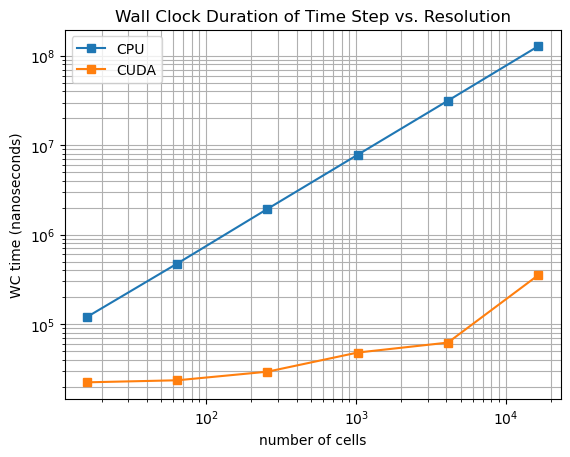

PyObject Text(0.5, 1.0, 'Wall Clock Duration of Time Step vs. Resolution')

In [61]:
fig, ax = subplots(1,1)

ax.set_xscale("log")
ax.set_yscale("log")

plot(nncellsC, meansC, label="CPU", marker="s") # yerr=stdevsC
plot(nncellsG, meansG, label="CUDA", marker="s") # yerr=stdevsG,

ylabel("WC time (nanoseconds)")
xlabel("number of cells")

legend()

grid(which="both")

title("Wall Clock Duration of Time Step vs. Resolution")

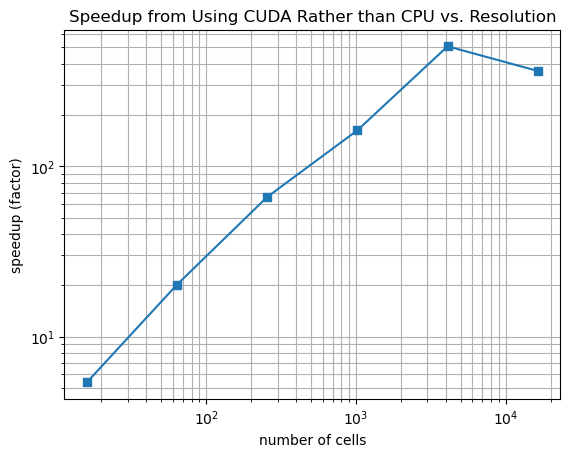

PyObject Text(0.5, 1.0, 'Speedup from Using CUDA Rather than CPU vs. Resolution')

In [63]:
fig, ax = subplots(1,1)

ax.set_xscale("log")
ax.set_yscale("log")

plot(nncells, meansC ./ meansG, marker="s")

ylabel("speedup (factor)")
xlabel("number of cells")

grid(which="both")

title("Speedup from Using CUDA Rather than CPU vs. Resolution")